In [2]:
import sys
sys.path.append("..")
from IPython.display import display

In [3]:
import numpy as np
import logging
import pickle
import time
%matplotlib inline
import matplotlib.pyplot as plt
import importlib 
plt.rcParams["figure.figsize"] = (8,8)

In [4]:
from scripts import reclusterTree
from scripts import linkageList
from scripts import heatClustermap
from scripts import Tree1D
from scripts import likelihood
from scripts import reclustGreedyLH
# from scripts import beamSearch
from scripts import beamSearchNumba as beamSearch
from scripts import beamSearch_list

In [15]:
# Reload filles after changes
importlib.reload(reclusterTree)
importlib.reload(linkageList)
importlib.reload(heatClustermap)
importlib.reload(Tree1D)
importlib.reload(likelihood)
importlib.reload(reclustGreedyLH)
importlib.reload(beamSearch)
importlib.reload(beamSearch_list)

<module 'scripts.beamSearch_list' from '/Users/sebastian/Dropbox/Documents/Physics_projects/simulator/TreeAlgorithms/scripts/beamSearch_list.py'>

In [6]:
# Data dir
input_dir= 'data/'
# input_dir ="../ToyJetsShower/data/"

In [7]:
input_jet = 'tree_13_truth'
# input_jet = 'tree_10_truth'

In [11]:
with open(input_dir+ str(input_jet) + '.pkl', "rb") as fd: 
    truth_jet = pickle.load(fd, encoding='latin-1')[0]

jet_name = ('_').join(input_jet.split('_')[-3:-1])
truth_jet["name"]=jet_name
truth_jet["algorithm"]="truth"

display(truth_jet["name"])

'tree_13'

In [16]:
# Fill list with log likelihood of truth jet
likelihood.enrich_jet_logLH(truth_jet)

In [17]:
truth_jet["logLH"]

[tensor(-2.5851),
 tensor(-2.1896),
 0,
 tensor(-1.9851),
 0,
 0,
 tensor(-0.2256),
 tensor(-1.9723),
 0,
 0,
 tensor(-1.6717),
 tensor(-2.1696),
 0,
 tensor(-1.8944),
 0,
 0,
 tensor(-2.1427),
 0,
 0]

In [9]:
# Number of jet constituents
linkageList.runTraverse_jet(truth_jet)
len(truth_jet["outers_list"])

10

In [10]:
# Recluster jet
recluster = False
if recluster:
    reclusterKt = reclusterTree.recluster(truth_jet, alpha=1, out_dir = "data/beamScanJets/")
    reclusterAntikt = reclusterTree.recluster(truth_jet, alpha=-1, out_dir = "data/beamScanJets/")
    reclusterCA = reclusterTree.recluster(truth_jet, alpha=0, out_dir = "data/beamScanJets/")

In [11]:
# Load reclustered jets
with open(input_dir+ str(truth_jet["name"])+'_1' + '.pkl', "rb") as fd: reclusterKt = pickle.load(fd, encoding='latin-1')
with open(input_dir+ str(truth_jet["name"])+'_-1' + '.pkl', "rb") as fd: reclusterAntikt = pickle.load(fd, encoding='latin-1')
with open(input_dir+ str(truth_jet["name"])+'_0' + '.pkl', "rb") as fd: reclusterCA = pickle.load(fd, encoding='latin-1')

# LIKELIHOOD BASED ALGORITHMS

## BEAM SEARCH

We implement a beam seach algorithm to find the tree that maximizes the log likelihood, given a certain beam size
beamSearch_jets is a sorted list of all the latent path that give the best total log likelihood, with size N_best.
beamSearch_jets[0] returns the jet with the greatest likelihood

In [143]:
importlib.reload(beamSearch)

<module 'scripts.beamSearchNumba' from '/Users/sebastian/Dropbox/Documents/Physics_projects/simulator/TreeAlgorithms/scripts/beamSearchNumba.py'>

In [144]:
# Global variables
beam_Size = 45
Nbest = 45

In [145]:
 np.asarray(truth_jet["Lambda"])

array(3.6, dtype=float32)

In [146]:
a=3
type(a)

int

In [147]:
np.int(6)


6

In [148]:
start_time = time.time() 

beamSearch_jets = beamSearch.recluster( 
    truth_jet, 
    beamSize = beam_Size,
    delta_min =   np.asarray(truth_jet["pt_cut"]),
    lam =  np.asarray(truth_jet["Lambda"]),
    N_best = Nbest,
)

elapsed_time = time.time()-start_time

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mInvalid use of Function(<class 'range'>) with argument(s) of type(s): (int64, range_state_int32)
Known signatures:
 * (int32,) -> range_state_int32
 * (int32, int32) -> range_state_int32
 * (int32, int32, int32) -> range_state_int32
 * (int64,) -> range_state_int64
 * (int64, int64) -> range_state_int64
 * (int64, int64, int64) -> range_state_int64
 * (uint64,) -> range_state_uint64
 * (uint64, uint64) -> range_state_uint64
 * (uint64, uint64, uint64) -> range_state_uint64
[1mIn definition 0:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 1:[0m
[1m    All templates rejected without literals.[0m
[1mThis error is usually caused by passing an argument of a type that is unsupported by the named function.[0m[0m
[0m[1m[1] During: resolving callee type: Function(<class 'range'>)[0m
[0m[1m[2] During: typing of call at /Users/sebastian/Dropbox/Documents/Physics_projects/simulator/TreeAlgorithms/scripts/beamSearchNumba.py (356)
[0m
[1m
File "scripts/beamSearchNumba.py", line 356:[0m
[1mdef level_SortedLogLH_beamPairs(
    <source elided>

[1m	# heapq is a min sort, so we push and pop each new item  => the paths with max logLH are the ones remaining in the queue
[0m [1m^[0m[0m

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


In [ ]:
print("Generation time for beam size of",beam_Size ,"= ",elapsed_time, "seconds")
print("Per beam average generation time =  ", elapsed_time/beam_Size," seconds")

In [149]:
print("Generation time for beam size of",beam_Size ,"= ",elapsed_time, "seconds")
print("Per beam average generation time =  ", elapsed_time/beam_Size," seconds")

Generation time for beam size of 45 =  2.558072090148926 seconds
Per beam average generation time =   0.05684604644775391  seconds


In [15]:
beamSearch_jets[0]["logLH"]

array([-1.98505843, -2.14269114, -0.30674982, -1.97229087, -0.46854436,
       -1.89435005, -2.16956115, -2.7541585 , -2.13510752])

In [16]:
np.sum(beamSearch_jets[0]["logLH"])

-15.828511834144592

### Beam Search jet visualizations

Beam Search LH JET


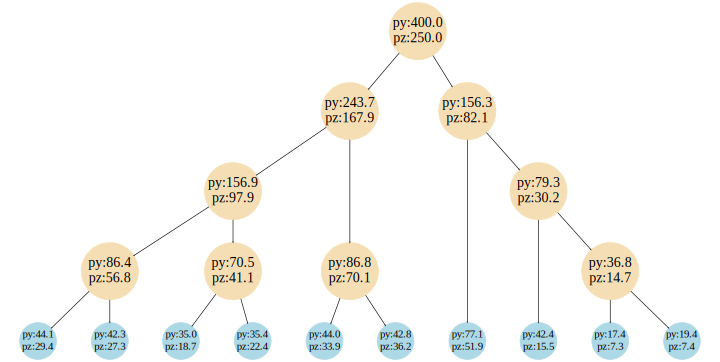

In [17]:
print('Beam Search LH JET')

tree = Tree1D.plotBinaryTree(
    beamSearch_jets[0],
    label=True,
    figFormat = "png",
)
tree.attr(rankdir='TB', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
# tree.render(filename="plots/1DTreeOnly/figBeamSize50_jet10")
display(tree)

2019-08-14 15:42:45,247:INFO::alpha row: beamSearch -- alpha column: beamSearch


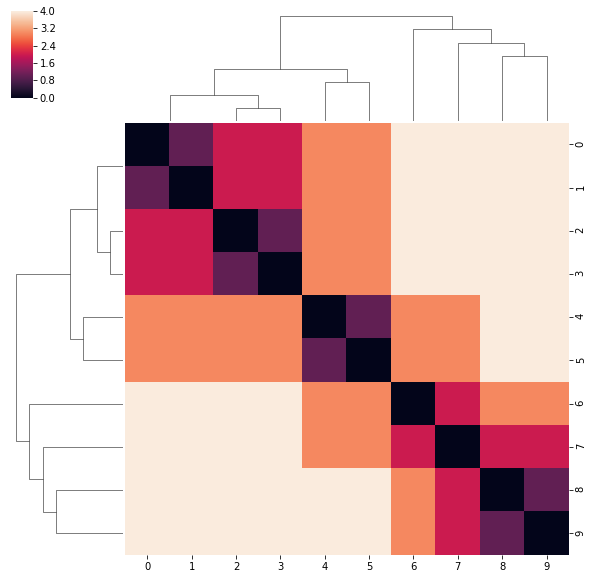

In [18]:
heatClustermap.heat_dendrogram(
    beamSearch_jet = beamSearch_jets[0],
    beamSize = beam_Size,
    N_best = Nbest,
    full_path=False, 
    FigName=None)

### Beam Search jet vs truth jet comparison

Leaves ordered according to truth jet - Beam Search jet with greatest LH (top) vs TRUTH (bottom) trees


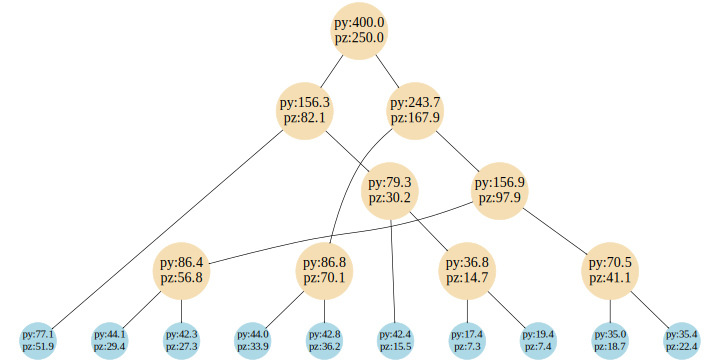

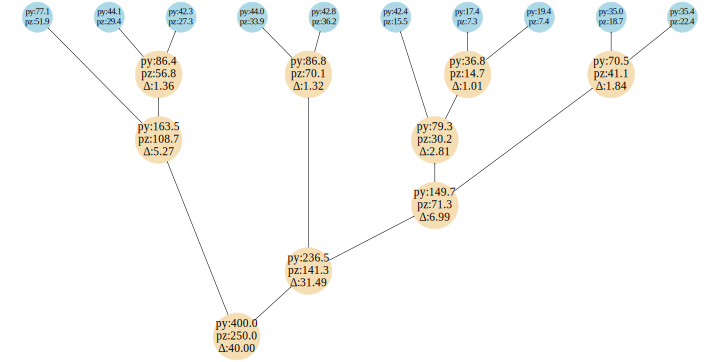

In [19]:
print("Leaves ordered according to truth jet - Beam Search jet with greatest LH (top) vs TRUTH (bottom) trees")
tree1, tree2 = Tree1D.visualizeTreePair(
    beamSearch_jets[0],
    truth_jet,
    truthOrder = True, 
    label=True,
)
tree1.attr(rankdir='TB', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
tree2.attr(rankdir='BT', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
display(tree1)
display(tree2)

Leaves ordered according to ANTIKT jet - Beam Search (top) vs ANTIKT (bottom) trees


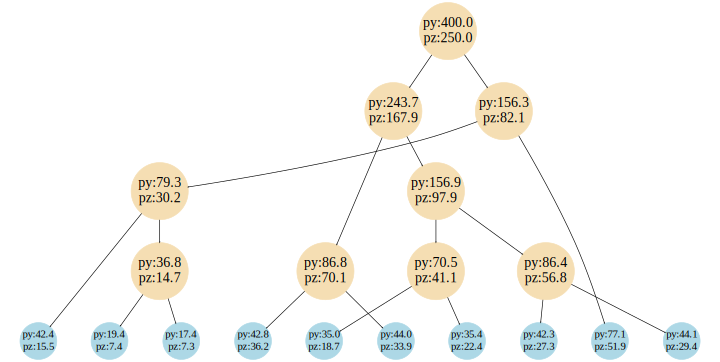

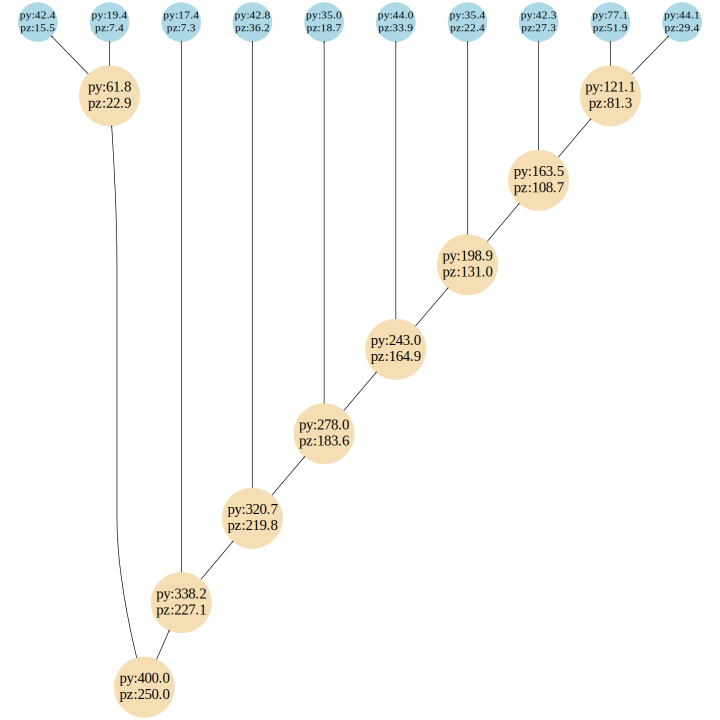

In [65]:
print("Leaves ordered according to ANTIKT jet - Beam Search (top) vs ANTIKT (bottom) trees")
tree1, tree2 = Tree1D.visualizeTreePair(
    reclusterAntikt,
    beamSearch_jets[0],
    truthOrder = False,
    label = True,
    alpha_jet1 =  -1,
    beamSize = beam_Size, 
    N_best = Nbest,
)
tree1.attr(rankdir='TB', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
tree2.attr(rankdir='BT', size="10",margin='0' ,ratio="1." , nodesep="0.01")
display(tree1)
display(tree2)

2019-08-14 15:42:55,567:INFO::alpha row: beamSearch -- alpha column: truth


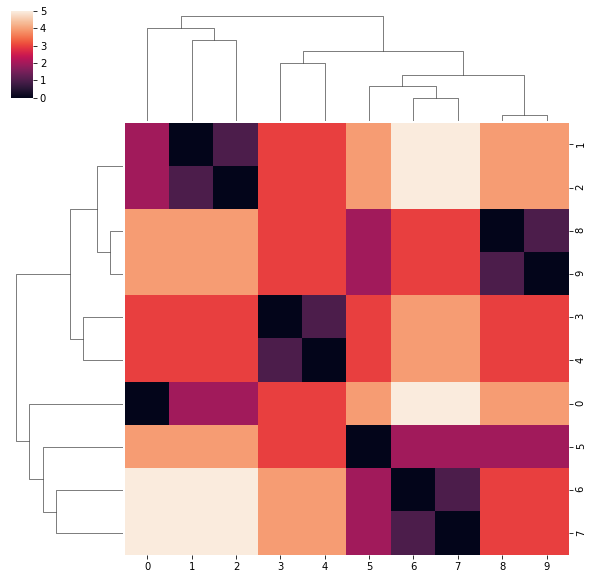

In [21]:
heatClustermap.heat_dendrogram(
    truthJet = truth_jet,
    beamSearch_jet = beamSearch_jets[0],
    full_path=False, 
    FigName=None,
)

2019-08-14 15:42:57,518:INFO::(Truth jet - recluster jet1) heat data


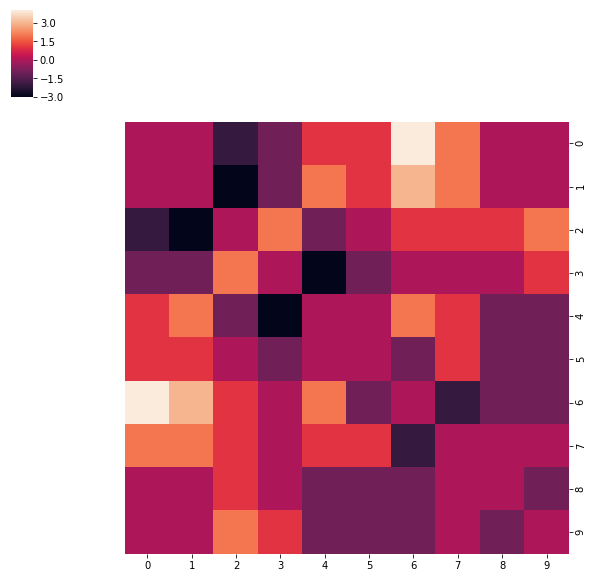

In [22]:
# outFilename="plots/heatClustermap/figDiffTruthBeamSize50_singlepath_jet10.jpg"
heatClustermap.dendrogramDiff(
    truthJet  = truth_jet,
    recluster_jet1 = beamSearch_jets[0],
    full_path=False, 
    FigName=None,
)

### Find latent path that gives the closest log likelihood to the truth jet: 

In [23]:
# truth jet total log likelihood
truth_logLH = np.sum(truth_jet["logLH"])
display(truth_logLH)

-16.83590602874756

In [24]:
def closest_logLHjet(in_beamSearch_jets, truth_jet):
    
    truth_logLH = np.sum(truth_jet["logLH"])
    path_logLH_diff = []
    
    for j,jet in enumerate(in_beamSearch_jets):
        path_logLH_diff.append([j, np.absolute(np.sum(in_beamSearch_jets[j]["logLH"]) - truth_logLH)])
    
    logLH_diff = sorted(path_logLH_diff, key=lambda x:x[1])

    return logLH_diff[0]

In [25]:
logLH_diff = closest_logLHjet(beamSearch_jets, truth_jet)
display(logLH_diff)

[2, 0.6900757551193237]

Beam Search jet with closest log LH to truth jet comaprison
Leaves ordered according to truth jet - Beam Search LH (top) vs TRUTH (bottom) trees


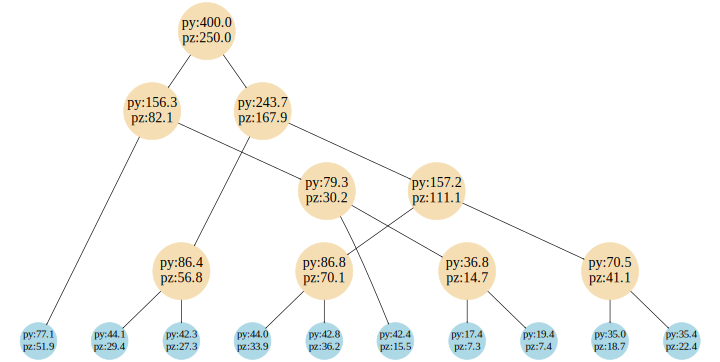

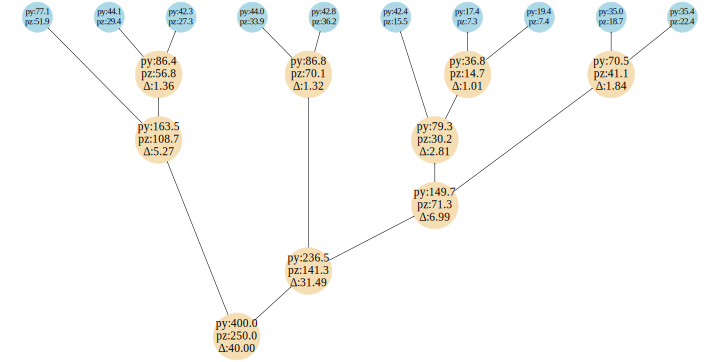

In [26]:
print("Beam Search jet with closest log LH to truth jet comaprison")
print("Leaves ordered according to truth jet - Beam Search LH (top) vs TRUTH (bottom) trees")
tree1, tree2 = Tree1D.visualizeTreePair(
    beamSearch_jets[logLH_diff[0]],
    truth_jet,
    truthOrder = True, 
    label = True,
    beamSize = beam_Size,
    N_best = Nbest,
)
tree1.attr(rankdir='TB', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
tree2.attr(rankdir='BT', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
display(tree1)
display(tree2)

2019-08-14 15:43:02,085:INFO::(Truth jet - recluster jet1) heat data


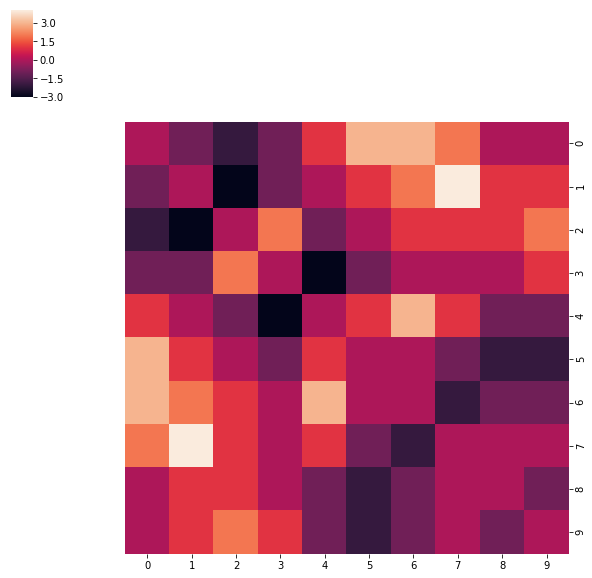

In [27]:
heatClustermap.dendrogramDiff(
    truthJet  = truth_jet,
    recluster_jet1= beamSearch_jets[logLH_diff[0]],
    full_path=False, 
    FigName=None,
)

### Compare log likelihood among the different latent paths

In [28]:
truthConst = beamSearch.getConstituents(
    truth_jet,	-1,
	truth_jet["root_id"],
	[],
)

In [29]:
maxlogLH_Trees, root_node = beamSearch.beamSearch(
                                                 truthConst,
                                                 beamSize= 20, 
                                                 delta_min =  truth_jet["pt_cut"]  , 
                                                 lam = truth_jet["Lambda"],
)

In [30]:
len(maxlogLH_Trees)

20

In [31]:
totPaths=[]
totLH =[]
for clustering in maxlogLH_Trees[::-1]:
    totPaths.append(clustering.logLH)
    totLH.append(np.sum(clustering.logLH))

In [32]:
# totLH

In [58]:
totPaths = np.asarray(totPaths)
totLH = np.asarray(totLH)
display(totLH - totLH[0])
# display(np.sort(totPaths[0]))
# display(np.sort(totPaths))
# display(totPaths - totPaths[0])
display(np.sort(totPaths) - np.sort(totPaths[0]))

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -1.18345213, -1.18345213, -1.18345213, -1.18345213,
       -1.18345213, -1.18345213, -1.77196598, -1.77196598, -4.22572803,
       -4.22572803, -4.22572803, -4.22572803, -4.22572803, -4.22572803])

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.07891083, -1.1045413 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.07891083, -1.1045413 ,  0.        ,  0.        ,  0

## GREEDY (STEP = 1 OPTIMIZATION)

In [36]:
# Recluster jet with greedy likelihood algorithm
greedyLH = reclustGreedyLH.recluster(
    truth_jet,
    delta_min =  truth_jet["pt_cut"] ,
    lam = truth_jet["Lambda"],
)

In [37]:
np.sum(greedyLH["logLH"]) 

-21.523842

In [38]:
np.asarray(greedyLH["logLH"])

array([-1.89435   , -1.9722909 ,  0.4995904 , -1.9850584 , -2.1426911 ,
       -0.30674982, -4.018512  , -3.960257  , -5.7435246 ], dtype=float32)

In [34]:
# truth jet total log likelihood
np.sum(truth_jet["logLH"])

-16.83590602874756

In [35]:
np.asarray(truth_jet["logLH"])

array([-2.58506131, -2.18959141,  0.        , -1.98505843,  0.        ,
        0.        , -0.22564268, -1.97229087,  0.        ,  0.        ,
       -1.67165995, -2.16956019,  0.        , -1.89435005,  0.        ,
        0.        , -2.14269114,  0.        ,  0.        ])

Greedy LH JET


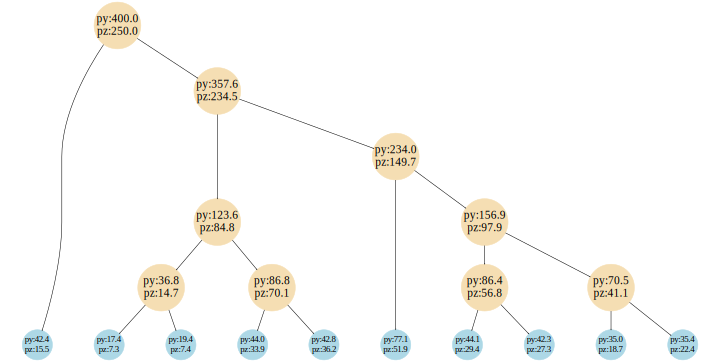

In [39]:
print('Greedy LH JET')
tree = Tree1D.plotBinaryTree(
    greedyLH, 
    label=True,
)
tree.attr(rankdir='TB', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
# tree.render(filename="../ToyJetsShower/notes/plots/figTruth_jet9")
display(tree)

Leaves ordered according to truth jet - Greedy LH (top) vs TRUTH (bottom) trees


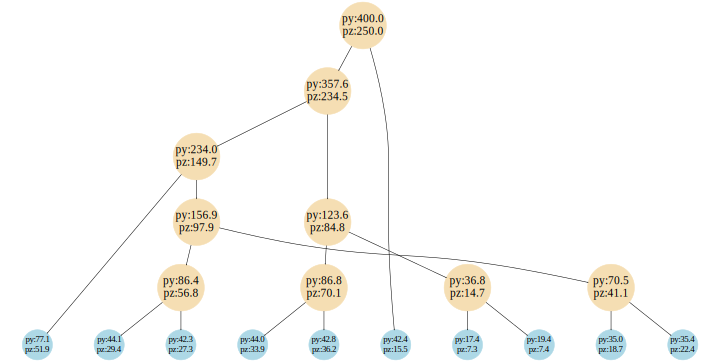

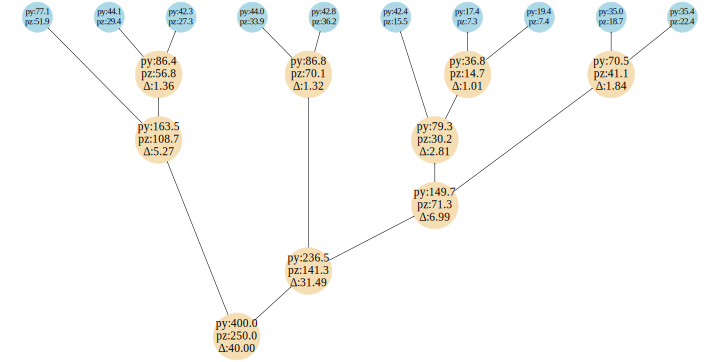

In [40]:
print("Leaves ordered according to truth jet - Greedy LH (top) vs TRUTH (bottom) trees")
tree1, tree2 = Tree1D.visualizeTreePair(
    greedyLH, 
    truth_jet,
    truthOrder = True,
    label = True,
)
tree1.attr(rankdir='TB', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
tree2.attr(rankdir='BT', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
display(tree1)
display(tree2)

Leaves ordered according to greedyLH jet - CA (top) vs greedyLH (bottom) trees


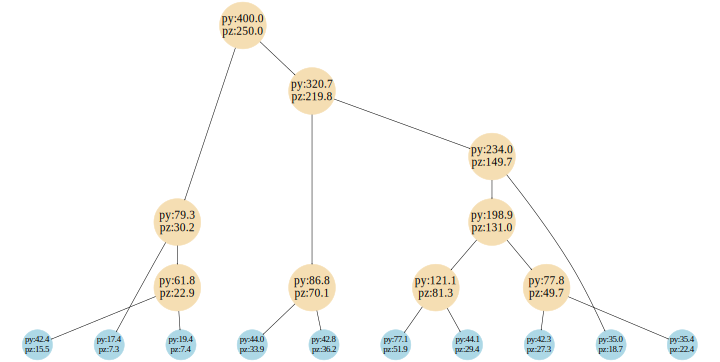

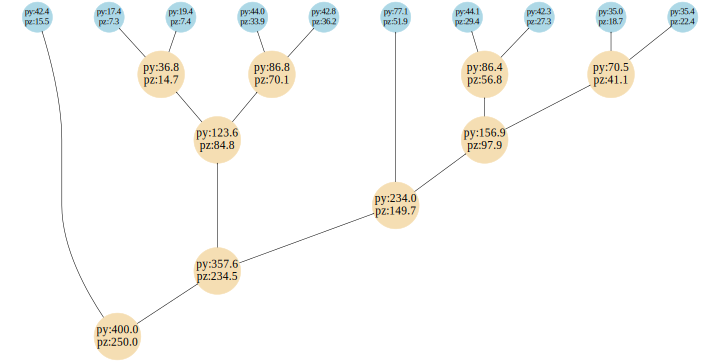

In [41]:
print("Leaves ordered according to greedyLH jet - CA (top) vs greedyLH (bottom) trees")
tree1, tree2 = Tree1D.visualizeTreePair(
    greedyLH, 
    reclusterCA,
    truthOrder = False,
    label = True,
    alpha_jet2 = 0,
)
tree1.attr(rankdir='TB', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
tree2.attr(rankdir='BT', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
display(tree1)
display(tree2)

In [42]:
# print("Leaves ordered according to CA jet - greedyLH (top) vs CA (bottom) trees")
# tree1, tree2 = Tree1D.visualizeTreePair(reclusterCA, greedyLH, truthOrder=False, label=True, alpha_jet1= 0)
# tree1.attr(rankdir='TB', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
# tree2.attr(rankdir='BT', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
# display(tree1)
# display(tree2)

## BEAM SEARCH VS GREEDY ALGORITHMS CROSS-CHECK 

The greedy algorithm should be a base case of the beam search. In particular they should be identical when the beam size is one.
We compare them for this case of beam size = 1 below and see that they give the same latent structure. 

In [43]:
beamSearch_jetsOne = beamSearch.recluster( 
    truth_jet, 
    beamSize = 1,
    delta_min =  truth_jet["pt_cut"],
    lam = truth_jet["Lambda"],
    N_best = 1,
)

In [44]:
beamSearch_jetsOne[0]["logLH"]

array([-1.89435005, -1.97229087,  0.4995904 , -1.98505843, -2.14269114,
       -0.30674982, -4.01851177, -3.96025705, -5.74352455])

In [45]:
greedyLH["logLH"]

array([-1.89435   , -1.9722909 ,  0.4995904 , -1.9850584 , -2.1426911 ,
       -0.30674982, -4.018512  , -3.960257  , -5.7435246 ], dtype=float32)

In [46]:
np.asarray(greedyLH["logLH"]) -  beamSearch_jetsOne[0]["logLH"]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

Leaves ordered according to greedyLH jet - Beam Search LH (top) vs greedyLH (bottom) trees


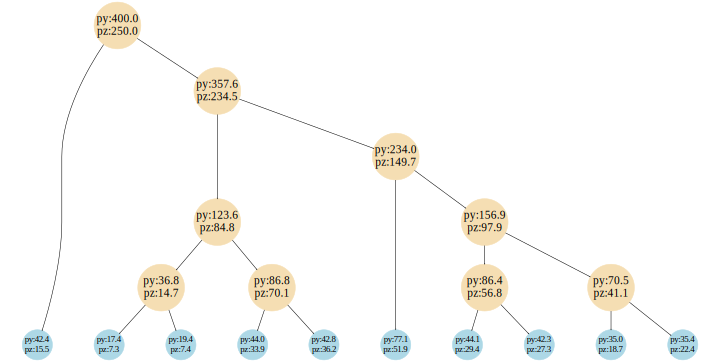

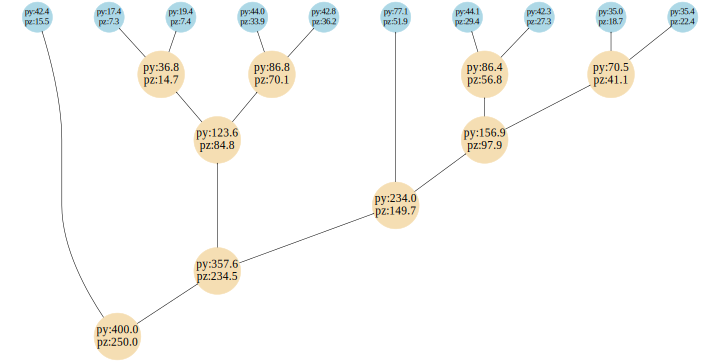

In [47]:
print("Leaves ordered according to greedyLH jet - Beam Search LH (top) vs greedyLH (bottom) trees")
tree1, tree2 = Tree1D.visualizeTreePair(
    greedyLH, 
    beamSearch_jetsOne[0],
    truthOrder = False, 
    label = True, 
    beamSize = 1,
    N_best = 1,
)
tree1.attr(rankdir='TB', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
tree2.attr(rankdir='BT', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
display(tree1)
display(tree2)

### The beam seach algorithm gives a greater jet log likelihood for a big enough beam size

In [48]:
beamSearch_jetsComp = beamSearch.recluster( 
    truth_jet, 
    beamSize = 45,
    delta_min =  truth_jet["pt_cut"],
    lam = truth_jet["Lambda"],
    N_best = 45,
)

In [49]:
# Beam search total log likelihood
np.sum(beamSearch_jetsComp[0]["logLH"])

-15.828511834144592

In [50]:
# truth jet total log likelihood
truth_logLH = np.sum(truth_jet["logLH"]) 
display(truth_logLH)

-16.83590602874756

In [51]:
# Greedy total log likelihood
np.sum(greedyLH["logLH"])

-21.523842